In [42]:
from IPython.display import Image

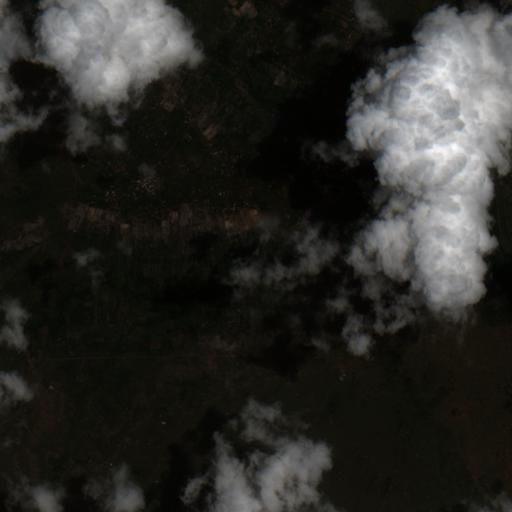

In [43]:
Image(data='/kaggle/input/ai4earth-mask-the-clouds/RGB_images/img/valt.jpeg')

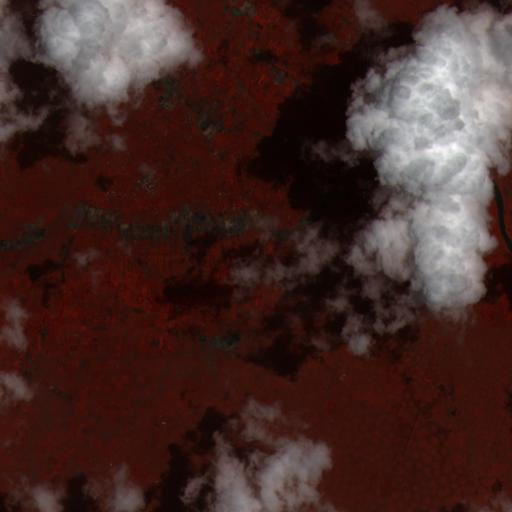

In [44]:
Image(data='/kaggle/input/ai4earth-mask-the-clouds/False_color/img/valt.jpeg')

# About 

Satellite imagery is critical for a wide variety of applications from disaster management and recovery, to agriculture, to military intelligence. Clouds present a major obstacle for all of these use cases, and usually have to be identified and removed from a dataset before satellite imagery can be used. Improving methods of identifying clouds can unlock the potential of an unlimited range of satellite imagery use cases, enabling faster, more efficient, and more accurate image-based research.

In this challenge, your goal is to detect cloud cover in satellite imagery to remove cloud interference. The challenge uses publicly available satellite data from the Sentinel-2 mission, which captures wide-swath, high-resolution, multi-spectral imaging. For each tile, data is separated into different bands of light across the full visible spectrum, near-infrared, and infrared light. Data is shared through Microsoft's Planetary Computer.

In this challenge, your goal is to label clouds in satellite imagery. In many uses of satellite imagery, clouds obscure what we really care about - for example, tracking wildfires, mapping deforestation, or visualizing crop health. Being able to more accurately remove clouds from satellite images filters out interference, unlocking the potential of a vast range of use cases.

**Hence to summarize, the goal of the competiton is to come up with better cloud detection algorithm for sentinel-2 Images**

src: https://www.drivendata.org/competitions/83/cloud-cover/page/396/

# Reference and Resources
* https://www.kaggle.com/brsdincer/cloud-coordinate-prediction-auto-encoder-dc-gan
* https://www.kaggle.com/cordmaur/remotesensing-fastai2-simpletraining
* https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html
* https://arxiv.org/pdf/2002.11434v1.pdf
* Running code on datadriven containers : https://www.drivendata.co/blog/code-execution-competitions/
* Submitting code : https://www.drivendata.org/competitions/83/cloud-cover/page/412/#what-to-submit


In [45]:
%autosave 200

Autosaving every 200 seconds


In [46]:
!nvidia-smi

Mon Sep 16 17:45:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             32W /  250W |   15771MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports 

In [47]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time



In [48]:
#progess bar 
from tqdm import tqdm

import cv2
from PIL import Image
import rasterio as rio
import imageio



In [49]:
#multiprocessing
import multiprocessing as mp
#deep learning
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

#backend
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings('ignore')

In [50]:
import os
import random 
import tensorflow as tf

BATCH= 8
img_size = (512,512)
seed=7

def set_seed(seed):
    '''set seed for reproducablity'''
    os.environ['PYTHONHASHSEED']= str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(seed)    

# Data directory

The Training Data Consists of Sentinel -2 Images in Blue(b2),Green(b3),Red(b4) and Near Infrared(b8), along with the corresponding cloud masks for each of the images.

In [51]:
#directories
import pandas as pd
rasters_dir ='/kaggle/input/sentinel2-drivendata-cloud-cover/data/train_features'
masks_dir  = '/kaggle/input/sentinel2-drivendata-cloud-cover/data/train_labels'

#metadata
metadata= pd.read_csv('/kaggle/input/sentinel2-drivendata-cloud-cover/data/train_metadata.csv')

In [52]:
print('Number of Unique locations are ',metadata.location.nunique())

Number of Unique locations are  81


# Helper Function 

**(Already extracted Images earlier,hence not running this part.)**

In [53]:
def load_img(path,expand_dim=False):
    img = cv2.imread(path)
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img / 255.0    
    if expand_dim:
        img = np.expand_dims(img,axis=0)
        
    return img

**Convert raster tif to composite jpeg images**

As the data is in seperate bands(Blue,Green,Red adn Near Infrared), I will combine the bands together to make RGB  and False Color(i.e (NIR,Green,Blue)) Composite Images in JPG format for each of the training data samples.

The Masks are also in tif format, hence converting them to JPG Images.

In [54]:
# make folders to save images
def make_folder(name,path):
    '''make a folder
    Inputs:
    name- name of the folder 
    path - path to be assigned to the folder'''
    
    if not os.path.exists(os.path.join(path,name)):
        os.makedirs(os.path.join(path,name))
        
    return os.path.join(path,name)


#root directory
#images_dir ='./working/' 

# images_dir = make_folder('Images',root_dir)
#folder to save rgb images

#make directories to save data
#rgb =make_folder('RGB_images/img',images_dir)
#false_color = make_folder('False_color/img',images_dir)
#asks = make_folder('Masks/img',images_dir)

In [55]:

def scale(band):
    '''scale a image by max value'''
    return band/np.max(band)

def convert_raster_to_image(rasters_dir,
                            rgb_path=None,
                            false_color=None):
    '''Stack of the raster bands in the directory (i.e bands 2,3,4,8) and convert to a image'''
    
    #read individual bands in image
    b2=scale(rio.open(rasters_dir+'/B02.tif').read().reshape(512,512,1))
    b3=scale(rio.open(rasters_dir+'/B03.tif').read().reshape(512,512,1))
    b4=scale(rio.open(rasters_dir+'/B04.tif').read().reshape(512,512,1))
    b8=scale(rio.open(rasters_dir+'/B08.tif').read().reshape(512,512,1))

    file_name = rasters_dir.split('/')[-1]
   

    #stack image bands for rgb image
    rgb = np.dstack([b4,b3,b2])
    
    plt.imsave(fname=rgb_path + f'/{file_name}.jpeg',
                arr=rgb)
#     cv2.imwrite(rgb_path + f'/{file_name}.jpeg',
#                 rgb.astype(np.uint8))

    #false color
    fc = np.dstack([b8,b3,b2])
    
    plt.imsave(fname=false_color + f'/{file_name}.jpeg',
                arr=fc)
    
#     cv2.imwrite(false_color + f'/{file_name}.jpeg',
#                 fc.astype(np.uint8))
    return None

def convert_mask_to_im(mask_path,
                       save_directory):
    '''convert a mask tiff file to image'''
    
    filename = mask_path.split('/')[-1]
    mask= rio.open(f'{mask_path}.tif').read().reshape(512,512,1)
    
    #cv2 imwrite expects val in range 0-255: 
    mask *= 255    
    
    cv2.imwrite(filename= save_directory + f'/{filename}.jpeg',  
                img=mask.astype(np.uint8))
    
    
    return None
    
    
# def convert_data(name,
#             rasters_dir=rasters_dir,
#             rgb_path=rgb,
#             false_color=false_color,
#             masks_dir=masks_dir,
#             save_mask=masks):
#     #save raster as image
#     dirn=os.path.join(rasters_dir,name)
    
    
#     _=convert_raster_to_image(dirn,
#                             rgb_path,
#                             false_color)

#     #save image mask
#     mask_dirn=os.path.join(masks_dir,
#                            name)
    
#     _=convert_mask_to_im(mask_dirn,
#                        save_directory=masks)
    
#     return None


In [56]:
# utils
def load_image(directory,name):
    path = os.path.join(directory,name)
    
    img = cv2.imread(path)
    return img

def plot_image_grid(image_list,
                    label_list,
                    sample_images=False,
                    num_images=6,
                    pre_title='class',
                    num_img_per_row=3,
                    cmap=None,
                    img_h_w=3):
    '''viz images from a list of images and labels
    INPUTS:
    image_list: a list of images to be plotted,
    label_list: a list of correspomding image labels'''
    


    #number of img rows
    n_row= num_images//num_img_per_row

    plt.subplots(n_row,num_img_per_row,figsize=(img_h_w*num_img_per_row,img_h_w*n_row))

    if sample_images:
    #select_random images 
        sampled_ids = random.choices(np.arange(0,len(image_list)),k=num_images)

        for i,idx in enumerate(sampled_ids):

            img = image_list[idx]
            label = label_list[i]
            plt.subplot(n_row,num_img_per_row,i+1)
            plt.title(f'{pre_title} - {label}')
            plt.axis('off')
            plt.imshow(img,cmap=cmap)
    else:
        for i,img in enumerate(image_list):

            label = label_list[i]
            plt.subplot(n_row,num_img_per_row,i+1)
            plt.title(f'{pre_title} - {label}')
            plt.axis('off')
            plt.imshow(img,cmap=cmap)

            # break the loop 
            if i==num_images-1 :
                  break 

    #show
    plt.tight_layout()
    plt.show()
    

**Creating Composite Images and masks (Images out of individual bands)**

Using multiprocessing to speed up the process of creating/saving images.

**I have already processed images, hence not doing this step**

In [57]:
# %%time
# pool =mp.Pool()
# create training images
# _=pool.map(convert_data,[name for name in tqdm(
#                                                 sorted(
#                                                     os.listdir(rasters_dir)
#                                                         )
#                                                 )
#                         ]
#           )

# # pool.join()
# pool.close()


# Loading Images and Masks in Generators

**Training Gen**

In [58]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                  validation_split=0.9)

# mask_datagen =  ImageDataGenerator(rescale=1/255,
#                                   validation_split=0.2)

#training data
#rgb images
BATCH = 8
rgb_dir = '/kaggle/input/ai4earth-mask-the-clouds/RGB_images'
rgb_gen = train_datagen.flow_from_directory(directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,
                                           seed=seed,
                                           subset='training')

#false color (nir,green,blue)
fc_dir = '/kaggle/input/ai4earth-mask-the-clouds/False_color'
fc_gen = train_datagen.flow_from_directory(
                                          directory=fc_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,seed=seed,
                                            subset='training')

#training labels
mask_dir ='/kaggle/input/ai4earth-mask-the-clouds/Masks'

mask_gen = train_datagen.flow_from_directory(
                                          directory=mask_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,seed=seed,
                                           subset='training')

rgb_val_gen = train_datagen.flow_from_directory(directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,
                                           seed=seed,
                                            subset='validation')

#false color (nir,green,blue)
fc_val_gen = train_datagen.flow_from_directory(
                                          directory=fc_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,seed=seed,
                                            subset='validation')

#training labels
mask_val_gen = train_datagen.flow_from_directory(
                                          directory=mask_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=None,
                                           shuffle=False,seed=seed,
                                           subset='validation')


Found 1175 images belonging to 1 classes.
Found 1175 images belonging to 1 classes.
Found 1175 images belonging to 1 classes.
Found 10573 images belonging to 1 classes.
Found 10573 images belonging to 1 classes.
Found 10573 images belonging to 1 classes.


In [ ]:
def apply_transformations(rgb_image, fc_image, mask_image):
    # Randomly apply transformations
    if random.random() > 0.5:
        # Apply random rotation between -30 and 30 degrees
        angle = random.uniform(-30, 30)
        rgb_image = ndi.rotate(rgb_image, angle, reshape=False)
        fc_image = ndi.rotate(fc_image, angle, reshape=False)
        mask_image = ndi.rotate(mask_image, angle, reshape=False)

    if random.random() > 0.5:
        # Apply horizontal flip
        rgb_image = np.fliplr(rgb_image)
        fc_image = np.fliplr(fc_image)
        mask_image = np.fliplr(mask_image)

    if random.random() > 0.5:
        # Apply vertical flip
        rgb_image = np.flipud(rgb_image)
        fc_image = np.flipud(fc_image)
        mask_image = np.flipud(mask_image)

    # Use the increase_brightness function you defined earlier
    if random.random() > 0.5:
        brightness_factor = random.uniform(1.0, 1.5)  # Random brightness factor between 1.0 and 1.5
        rgb_image = increase_brightness(rgb_image, brightness_factor)
        fc_image = increase_brightness(fc_image, brightness_factor)  # You can enhance brightness in FC images too

    # Apply histogram equalization on the RGB and FC images
    if random.random() > 0.5:
        rgb_image = histogram_equalization(rgb_image)
        fc_image = histogram_equalization(fc_image)
    
    return rgb_image, fc_image, mask_image

In [63]:
import os
import shutil

# Path to the working directory
working_dir = '/kaggle/working'

# Iterate over all items in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    
    # Check if it's a directory
    if os.path.isdir(item_path):
        # Remove the directory and its contents
        shutil.rmtree(item_path)
        print(f"Deleted directory: {item_path}")


Deleted directory: /kaggle/working/processed_image


In [64]:
os.mkdir('processed_image')
os.mkdir('processed_image_FC')
os.mkdir('processed_image_M')

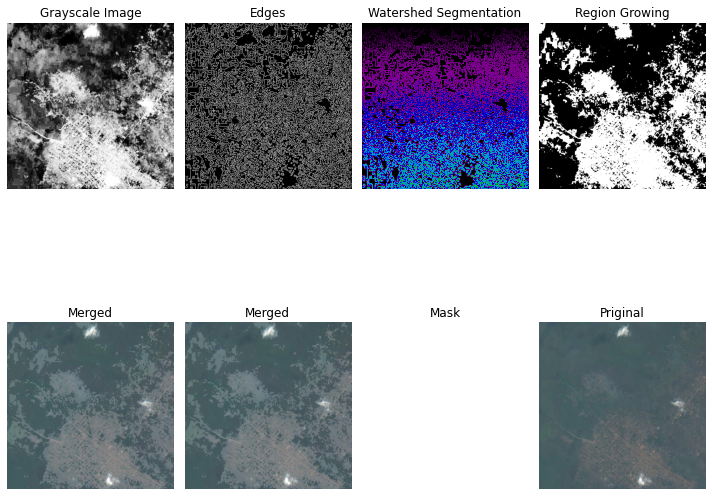

In [66]:
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
from skimage import feature, morphology, segmentation, filters
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os

def increase_brightness(image, factor):
    image_pil = Image.fromarray((image * 255).astype(np.uint8))  
    enhancer = ImageEnhance.Brightness(image_pil)
    image_bright = enhancer.enhance(factor)
    return np.array(image_bright) / 255.0 

def histogram_equalization(image):
    image_pil = Image.fromarray((image * 255).astype(np.uint8)) 
    image_equalized = ImageOps.equalize(image_pil)
    return np.array(image_equalized) / 255.0  


output_dir = '/kaggle/working/processed_image'
output_dir2 = '/kaggle/working/processed_image_FC'
output_dir3 = '/kaggle/working/processed_image_M'

steps_per_epoch = len(rgb_gen)
didnt = True
im_di = 0
for _ in range(3) :
    for step in range(steps_per_epoch):

        rgb_images = rgb_gen.next()
        false_color_images = fc_gen.next()
        masks = mask_gen.next()

        for i in range(rgb_images.shape[0]):
            image = rgb_images[i]

            if image.shape[-1] == 3:  
                image_pil = Image.fromarray((image * 255).astype(np.uint8))  
                image_gray = np.array(image_pil.convert('L')) / 255.0 
            else:
                image_gray = image 
            rgb_image = rgb_images[i] 
            fc_image = false_color_images[i]
            mask_image = masks[i]
            
            image_gray = histogram_equalization(image_gray)
            edges = feature.canny(image_gray)
            distance = ndi.distance_transform_edt(edges)
            markers = ndi.label(edges)[0]
            labels_ws = segmentation.watershed(-distance, markers, mask=edges)
            image_bright = increase_brightness(image, 1.1)
            #=>  minimizing the intra-class variance
            #=> Intra-class variance refers to the variation or spread of pixel intensity values within a single class or group in an image. In the context of image segmentation, it is typically used to measure how similar the pixel intensities are within each class (e.g., foreground and background).
            #=> is used to separate the pixels into two classes: background and foreground.
            #=> if a pixel's intensity is greater than the threshold, it is considered part of the "foreground" (true), and otherwise, it is considered "background" (false).
            threshold = filters.threshold_otsu(image_gray)
            region_grown = image_gray > threshold
            alpha = 0.9

            merged_image = np.clip(alpha * image_bright + (1 - alpha) * region_grown.reshape(region_grown.shape[0],region_grown.shape[1],1), 0, 1) 
            Image.fromarray((merged_image * 255).astype(np.uint8)).save(os.path.join(output_dir, f'training_image_{im_di}_merged.png'))
            Image.fromarray((false_color_images[i] * 255).astype(np.uint8)).save(os.path.join(output_dir2, f'training_image_{im_di}_merged.png'))
            Image.fromarray((masks[i] * 255).astype(np.uint8)).save(os.path.join(output_dir3, f'training_image_{im_di}_merged.png'))

            im_di = im_di + 1

            transformed_rgb_image, transformed_fc_image, transformed_mask_image = apply_transformations(rgb_image, fc_image, mask_image)

            Image.fromarray((transformed_rgb_image * 255).astype(np.uint8)).save(os.path.join(output_dir, f'training_image_{im_di}_aug.png'))
            Image.fromarray((transformed_fc_image * 255).astype(np.uint8)).save(os.path.join(output_dir2, f'training_image_{im_di}_aug.png'))
            Image.fromarray((transformed_mask_image * 255).astype(np.uint8)).save(os.path.join(output_dir3, f'training_image_{im_di}_aug.png'))


            im_di = im_di + 1

            if didnt:
                didnt = False
                fig, axes = plt.subplots(2, 4, figsize=(10, 10))
                ax = axes.ravel()

                ax[0].imshow(image_gray, cmap='gray')
                ax[0].set_title('Grayscale Image')

                ax[1].imshow(edges, cmap='gray')
                ax[1].set_title('Edges')

                ax[2].imshow(labels_ws, cmap='nipy_spectral')
                ax[2].set_title('Watershed Segmentation')

                ax[3].imshow(region_grown, cmap='gray')
                ax[3].set_title('Region Growing')

                ax[4].imshow(merged_image, cmap='gray')
                ax[4].set_title('Merged')

                ax[5].imshow(merged_image, cmap='gray')
                ax[5].set_title('Merged')

                ax[6].imshow(masks[i])
                ax[6].set_title('Mask')

                ax[7].imshow(image)
                ax[7].set_title('Priginal')

                for a in ax:
                    a.axis('off')

                plt.tight_layout()
                plt.show()


In [67]:
os.mkdir('processed_image_val')
os.mkdir('processed_image_val_FC')
os.mkdir('processed_image_val_M')

In [68]:
output_dir = '/kaggle/working/processed_image_val/'
output_dir2 = '/kaggle/working/processed_image_val_FC/'
output_dir3 = '/kaggle/working/processed_image_val_M/'

# Process all images and save
steps_per_epoch = len(rgb_val_gen)
didnt = True
stop = 1000
for step in range(steps_per_epoch):
    # Get a batch of images and masks
    rgb_images = rgb_val_gen.next()
    false_color_images = fc_val_gen.next()
    masks = mask_val_gen.next()

    # Process each image in the batch
    for i in range(rgb_images.shape[0]):
        image = rgb_images[i]
        
        if image.shape[-1] == 3:  
            image_pil = Image.fromarray((image * 255).astype(np.uint8))  
            image_gray = np.array(image_pil.convert('L')) / 255.0 
        else:
            image_gray = image 

        rgb_image = rgb_images[i] 
        fc_image = false_color_images[i]
        mask_image = masks[i]
        
        image_gray = histogram_equalization(image_gray)
        edges = feature.canny(image_gray)
        distance = ndi.distance_transform_edt(edges)
        markers = ndi.label(edges)[0]
        labels_ws = segmentation.watershed(-distance, markers, mask=edges)
        image_bright = increase_brightness(image, 1.1)
        threshold = filters.threshold_otsu(image_gray)
        region_grown = image_gray > threshold
        alpha = 0.7
        
        merged_image = np.clip(alpha * image_bright + (1 - alpha) * region_grown.reshape(region_grown.shape[0],region_grown.shape[1],1), 0, 1) 
        Image.fromarray((merged_image * 255).astype(np.uint8)).save(os.path.join(output_dir, f'validation_image_{im_di}_merged.png'))
        Image.fromarray((false_color_images[i] * 255).astype(np.uint8)).save(os.path.join(output_dir2, f'validation_image_{im_di}_merged.png'))
        Image.fromarray((masks[i] * 255).astype(np.uint8)).save(os.path.join(output_dir3, f'validation_image_{im_di}_merged.png'))

        im_di = im_di + 1
                
        stop = stop + 1
        if stop :
            break
        
        if didnt:
            didnt = False
            fig, axes = plt.subplots(2, 4, figsize=(10, 10))
            ax = axes.ravel()

            ax[0].imshow(image_gray, cmap='gray')
            ax[0].set_title('Grayscale Image')

            ax[1].imshow(edges, cmap='gray')
            ax[1].set_title('Edges')

            ax[2].imshow(labels_ws, cmap='nipy_spectral')
            ax[2].set_title('Watershed Segmentation')

            ax[3].imshow(region_grown, cmap='gray')
            ax[3].set_title('Region Growing')

            ax[4].imshow(merged_image, cmap='gray')
            ax[4].set_title('Merged')

            ax[5].imshow(merged_image, cmap='gray')
            ax[5].set_title('Merged')

            ax[6].imshow(masks[i])
            ax[6].set_title('Mask')

            ax[7].imshow(image)
            ax[7].set_title('Priginal')

            for a in ax:
                a.axis('off')

            plt.tight_layout()
            plt.show()
    

In [81]:

rgb_dir = '/kaggle/working'

BATCH = 8
rgb_gen = train_datagen.flow_from_directory(directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           shuffle=False,
                                           seed=seed,
                                            classes=["processed_image"], 
                                           )

#false color (nir,green,blue)
fc_dir = '/kaggle/input/ai4earth-mask-the-clouds/False_color'
fc_gen = train_datagen.flow_from_directory(
                                          directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=["processed_image_FC"],
                                           shuffle=False,seed=seed,
                                            )

#training labels
mask_dir ='/kaggle/input/ai4earth-mask-the-clouds/Masks'
mask_gen = train_datagen.flow_from_directory(
                                          directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=["processed_image_M"],
                                           shuffle=False,seed=seed,
                                           )



Found 7050 images belonging to 1 classes.
Found 7050 images belonging to 1 classes.
Found 7050 images belonging to 1 classes.


**Validation Gen**

In [82]:
# validation data 

#training data
#rgb images
rgb_dir = '/kaggle/working'

rgb_val_gen = train_datagen.flow_from_directory(directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=["processed_image_val"],
                                           shuffle=False,
                                           seed=seed,
                                            )

#false color (nir,green,blue)
fc_val_gen = train_datagen.flow_from_directory(
                                          directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=["processed_image_val_FC"],
                                           shuffle=False,seed=seed,
                                            )

#training labels
mask_val_gen = train_datagen.flow_from_directory(
                                          directory=rgb_dir,
                                           target_size= img_size,
                                           batch_size=BATCH,
                                           class_mode=None,
                                           classes=['processed_image_val_M'],
                                           shuffle=False,seed=seed,
                                          )


Found 2644 images belonging to 1 classes.
Found 2644 images belonging to 1 classes.
Found 2644 images belonging to 1 classes.


**Zip the datagenerators together as a generator**

In [83]:
#https://stackoverflow.com/questions/56517963/keras-imagedatagenerator-for-segmentation-with-images-and-masks-in-separate-dire
def zip_generators(rgb_gen=rgb_gen, #rgb images
                   fc_gen=fc_gen,   # false color images
                   mask_gen=mask_gen): # mask images 
    
    tr_img_generator = zip(rgb_gen,fc_gen)
    train_generator = zip(tr_img_generator, mask_gen)
    for (imgs, mask) in train_generator:
        yield (imgs, mask)
        
        
train_gen = zip_generators()

val_gen = zip_generators(rgb_val_gen,
                         fc_val_gen,
                         mask_val_gen)

# Visualize some images

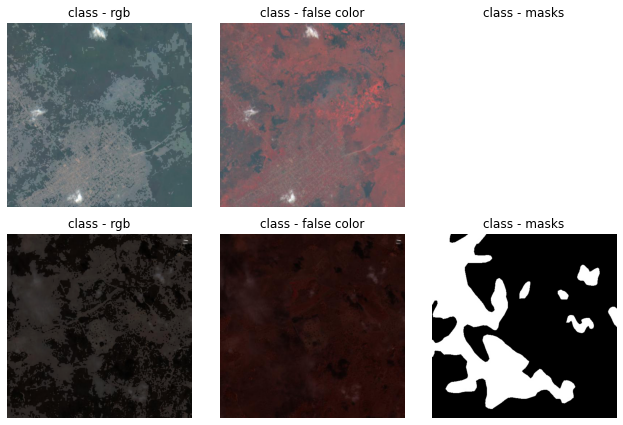

In [84]:
num=6

# RGB

rgb_im = list(rgb_gen.next())
rgb_lab = ['rgb' for _ in range(len(rgb_im))]

#false color images
fc_im = list(fc_gen.next())
fc_lab = ['false color' for _ in range(len(fc_im))]

#masks
msk_im = list(mask_gen.next())
msk_lab = ['masks' for _ in range(len(fc_im))]

viz_list=[]
lab_list=[]
for i in range(BATCH):
    viz_list.extend([rgb_im[i],fc_im[i],msk_im[i]])
    lab_list.extend([rgb_lab[i],fc_lab[i],msk_lab[i]])


plot_image_grid(viz_list,
                lab_list,
                num_images=num,
                num_img_per_row=3)

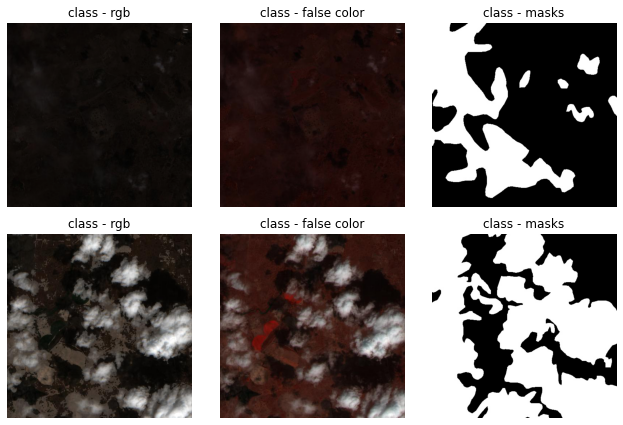

In [85]:
plot_image_grid(viz_list[6:],
                lab_list[6:],
                num_images=num,
                num_img_per_row=3)

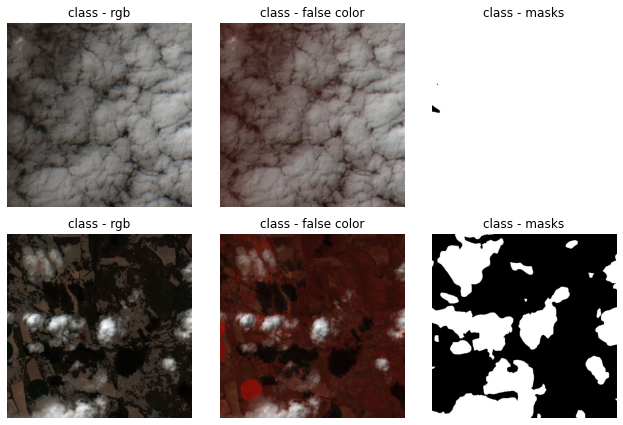

In [86]:
num=6

# RGB

rgb_im = list(rgb_gen.next())
rgb_lab = ['rgb' for _ in range(len(rgb_im))]

#false color images
fc_im = list(fc_gen.next())
fc_lab = ['false color' for _ in range(len(fc_im))]

#masks
msk_im = list(mask_gen.next())
msk_lab = ['masks' for _ in range(len(fc_im))]

viz_list=[]
lab_list=[]
for i in range(4):
    viz_list.extend([rgb_im[i],fc_im[i],msk_im[i]])
    lab_list.extend([rgb_lab[i],fc_lab[i],msk_lab[i]])


plot_image_grid(viz_list,
                lab_list,
                num_images=num,
                num_img_per_row=3)

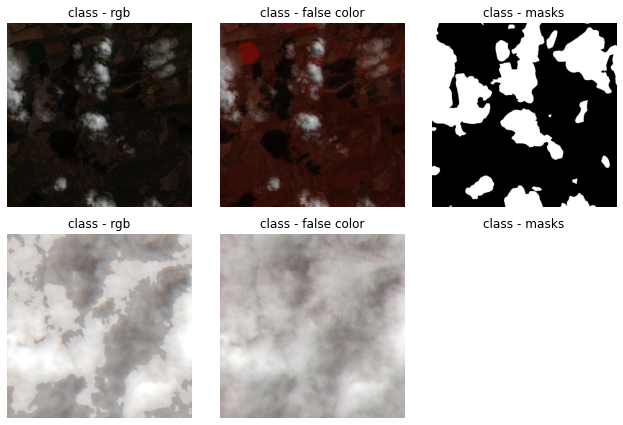

In [87]:
plot_image_grid(viz_list[6:],
                lab_list[6:],
                num_images=num,
                num_img_per_row=3)

# Building Segmentation Model

* The model has two Inputs, one with RGB image and other with False color Image.
* It is followed by a Convolution, BatchNorm and Relu Activation on both the input Images. 
* The next layer involves concating the outputs from two previous outputs(one with RGB,other with FC).
* the rest of the network is a Inception type UNET architecture(from https://keras.io/examples/vision/oxford_pets_image_segmentation/).


In [88]:
class Xception_Unet():
    def __init__(self,
                img_size=img_size,
                num_classes=1):
        self.img_size=img_size
        self.num_classes=num_classes
        
    def build_cnn(self):
        #model from https://keras.io/examples/vision/oxford_pets_image_segmentation/
        input1 = layers.Input(shape=self.img_size + (3,))
        input2 =layers.Input(shape=self.img_size + (3,))


        ### [First half of the network: downsampling inputs] ###
        # Entry block
        x1 = layers.Conv2D(32, 3, strides=2, padding="same")(input1)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Activation("relu")(x1)

        x2 = layers.Conv2D(32, 3, strides=2, padding="same")(input2)
        x2 = layers.BatchNormalization()(x2)
        x2 = layers.Activation("relu")(x2)

        x= layers.Concatenate()([x1,x2])


        previous_block_activation = x  # Set aside residual

        # Blocks 1, 2, 3 are identical apart from the feature depth.
        for filters in [64,128,256]:
            x = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

            # Project residual
            residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
                previous_block_activation
            )
            x = layers.add([x, residual])  # Add back residual
            previous_block_activation = x  # Set aside next residual

        ### [Second half of the network: upsampling inputs] ###

        for filters in [256,128,64,32]:
            x = layers.Activation("relu")(x)
            x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.Activation("relu")(x)
            x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.UpSampling2D(2)(x)

            # Project residual
            residual = layers.UpSampling2D(2)(previous_block_activation)
            residual = layers.Conv2D(filters, 1, padding="same")(residual)
            x = layers.add([x, residual])  # Add back residual
            previous_block_activation = x  # Set aside next residual


        # Add a per-pixel classification layer
        output = layers.Conv2D(self.num_classes, 3, activation="sigmoid", padding="same")(x)


        model = Model(inputs=[input1,input2],outputs=output)

        return model

# Custom Loss
 
* Using Power Jaccard Distance as Loss. (as discussed here : https://hal.archives-ouvertes.fr/hal-03139997/document). 

* Jaccard Index (Intersection Over Union) :

![](https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png)
!['IOU Ex'](https://upload.wikimedia.org/wikipedia/commons/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png)

In [95]:
class power_jaccard_loss(tf.keras.losses.Loss):
    '''
        Generalized loss function called Power
    Jaccard Loss including a power term p to the Jaccard
    loss of (1) in order to increase the weight of wrong
    predictions during training, as follows:
    Jp(y,ˆy,p) = 1 − (y*ˆy)+ε / (y^p + ˆy^p −y*ˆy)+ε
    
    src : https://hal.archives-ouvertes.fr/hal-03139997/document
    '''
    def __init__(self,
                 smooth=10, #smoothing
                 epsilon=1e-7, #prevents zero division
                 power = 1.5
                ):
        super().__init__()
        self.smooth=smooth
        self.pow = power
        self.epsilon = epsilon
    
    def call(self,
             y_true,
             y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1) #intersection
        union = K.sum(K.pow(K.abs(y_true),self.pow) + K.pow(K.abs(y_pred),self.pow),
                      axis=-1) #union
        
        jacc = (intersection + self.epsilon) / (union - intersection + self.epsilon) # jaccard index
        
        return (1 - jacc) * self.smooth

    
    
# class IOU(tf.keras.metrics.Metric):
#     def __init__(self,
#                  smooth=100):
#         super().__init__()
#         self.smooth=smooth
    
def IOU(y_true,
         y_pred,
        epsilon=1e-7):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1) #intersection
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1) #union

    jacc = (intersection + epsilon) / (union - intersection + epsilon) # jaccard index

    return jacc

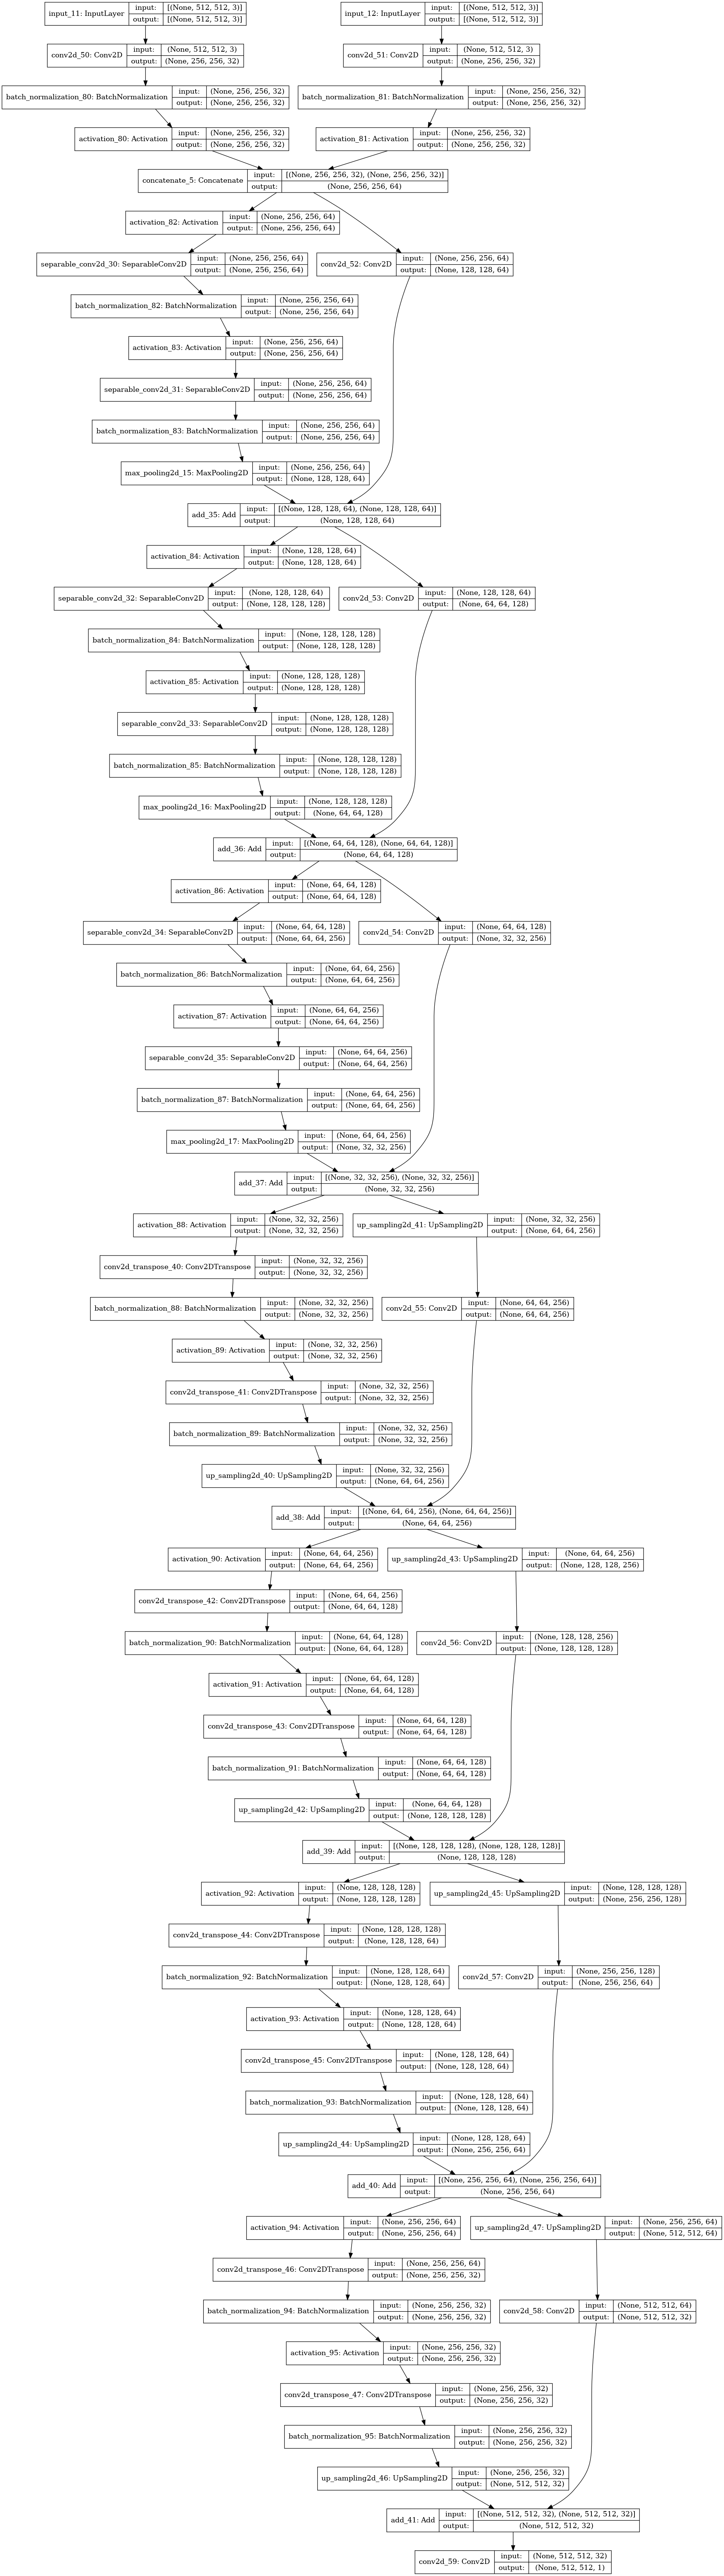

In [96]:
#build model
import torch
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model= Xception_Unet(img_size=img_size,
                      num_classes=1).build_cnn()

#compile model with our custom loss
compile_params ={'loss'      :power_jaccard_loss(power=1.25,
                                                 smooth = 100),
                'optimizer'  :'rmsprop',
                'metrics'    :[IOU]}
#compile 
model.compile(**compile_params)


#plot model
tf.keras.utils.plot_model(model,
                          show_shapes=True)

# Fit model

In [97]:
EPOCHS=30

# callbacks 
#reduce_learning rate
reduce_lr=ReduceLROnPlateau(patience=2,
                            factor=0.1,
                            min_delta=1e-5,
                            monitor='val_loss',
                            verbose=1,
                            mode='min')

#early stopping 
early_stopping=EarlyStopping(patience=4,
                             min_delta=1e-5,
                              monitor='val_loss',
                              restore_best_weights=True,
                              mode='min')
def optimize_tpu():
    xm.optimizer_step(optimizer, barrier=True)


_=model.fit_generator(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    steps_per_epoch=rgb_gen.n//BATCH,
                    validation_steps = rgb_val_gen.n//BATCH,
                    validation_freq=1,
                    callbacks=[reduce_lr,early_stopping])

Epoch 1/30
881/881 [==============================] - 455s 512ms/step - loss: 19.9268 - IOU: 0.8005 - val_loss: 31.3300 - val_IOU: 0.6867
Epoch 2/30
881/881 [==============================] - 454s 515ms/step - loss: 16.5412 - IOU: 0.8346 - val_loss: 19.6878 - val_IOU: 0.8031
Epoch 3/30
881/881 [==============================] - 456s 517ms/step - loss: 14.7269 - IOU: 0.8527 - val_loss: 18.3914 - val_IOU: 0.8161
Epoch 4/30
881/881 [==============================] - 452s 513ms/step - loss: 12.6260 - IOU: 0.8737 - val_loss: 18.0161 - val_IOU: 0.8198
Epoch 5/30
881/881 [==============================] - 457s 519ms/step - loss: 12.7823 - IOU: 0.8721 - val_loss: 30.6843 - val_IOU: 0.6931
Epoch 6/30
881/881 [==============================] - 453s 514ms/step - loss: 11.7840 - IOU: 0.8821 - val_loss: 19.3480 - val_IOU: 0.8065

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
881/881 [==============================] - 454s 515ms/step - loss: 10.1752 - IO

# Saving Model

In [98]:
#saving model

models = 'saved_models'

if not os.path.exists('./'+ models):
    os.mkdir(models)
    
model_path = os.path.join(models,'seg_model.h5')
model.save(filepath=model_path)

# Visualizing Model Predictions

In [104]:
#root directory
images_dir ='./working/' 
root_dir = '/kaggle/working'
images_dir = make_folder('Images',root_dir)
#folder to save rgb images

#make directories to save data
rgb =make_folder('RGB_images/img',images_dir)
false_color = make_folder('False_color/img',images_dir)
asks = make_folder('Masks/img',images_dir)

In [107]:
rgb_dir = '/kaggle/input/ai4earth-mask-the-clouds/RGB_images'

In [119]:
rgb= rgb_dir + '/img/' 
false_color=fc_dir+ '/img/'
masks =mask_dir+ '/img/'

rand_chk = np.random.choice(len(os.listdir(rgb)),size=10)

ls = [os.listdir(rgb)[i] for i in rand_chk]
ls 

['rxim.jpeg',
 'dcqc.jpeg',
 'bwju.jpeg',
 'peno.jpeg',
 'xsdg.jpeg',
 'xcbm.jpeg',
 'wgpv.jpeg',
 'tbnv.jpeg',
 'vbem.jpeg',
 'jdmz.jpeg']

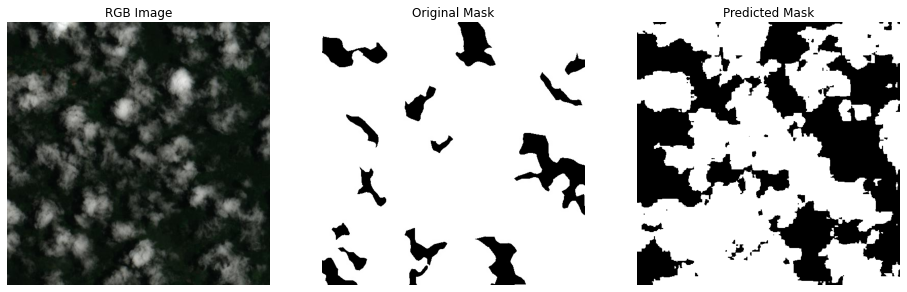

In [118]:
img = (load_img(os.path.join(rgb,ls[0]),expand_dim=True),
       load_img(os.path.join(false_color,ls[0]),expand_dim=True))
msk = cv2.imread(os.path.join(masks,ls[0]))
pred = model.predict(img)

fig,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].set_title('RGB Image')
ax[0].imshow(img[0][0,:,:,::-1])
ax[0].axis('off')

ax[1].set_title('Original Mask')
ax[1].imshow(msk)
ax[1].axis('off')

ax[2].set_title('Predicted Mask')
ax[2].axis('off')
ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred[0]>0.5),cmap='gray')

plt.show()

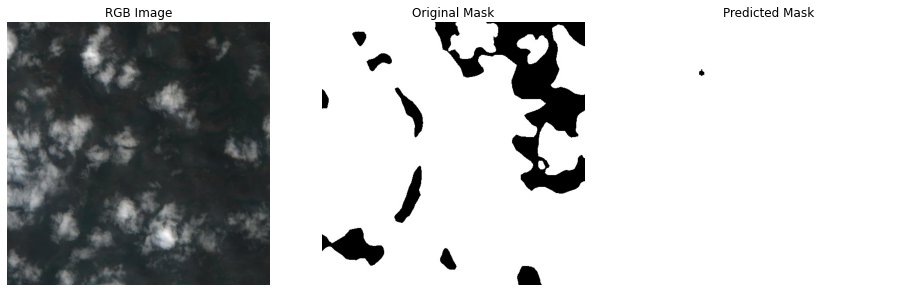

In [120]:
img = (load_img(os.path.join(rgb,ls[1]),expand_dim=True),
       load_img(os.path.join(false_color,ls[1]),expand_dim=True))
msk = cv2.imread(os.path.join(masks,ls[1]))
pred = model.predict(img)

fig,ax=plt.subplots(1,3,figsize=(16,8))
ax[0].set_title('RGB Image')
ax[0].imshow(img[0][0,:,:,::-1])
ax[0].axis('off')

ax[1].set_title('Original Mask')
ax[1].imshow(msk)
ax[1].axis('off')

ax[2].set_title('Predicted Mask')
ax[2].axis('off')
ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred[0]>0.5),cmap='gray')

plt.show()

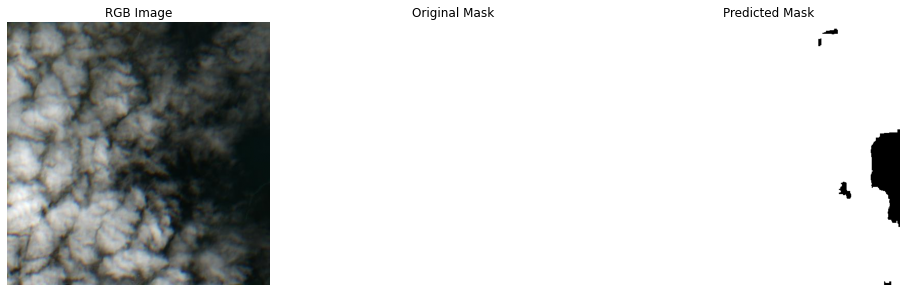

In [121]:
img = (load_img(os.path.join(rgb,ls[2]),expand_dim=True),
       load_img(os.path.join(false_color,ls[2]),expand_dim=True))
msk = cv2.imread(os.path.join(masks,ls[2]))
pred = model.predict(img)

fig,ax=plt.subplots(1,3,figsize=(16,8))
ax[0].set_title('RGB Image')
ax[0].imshow(img[0][0,:,:,::-1])
ax[0].axis('off')

ax[1].set_title('Original Mask')
ax[1].imshow(msk)
ax[1].axis('off')

ax[2].set_title('Predicted Mask')
ax[2].axis('off')
ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred[0]>0.5),cmap='gray')

plt.show()

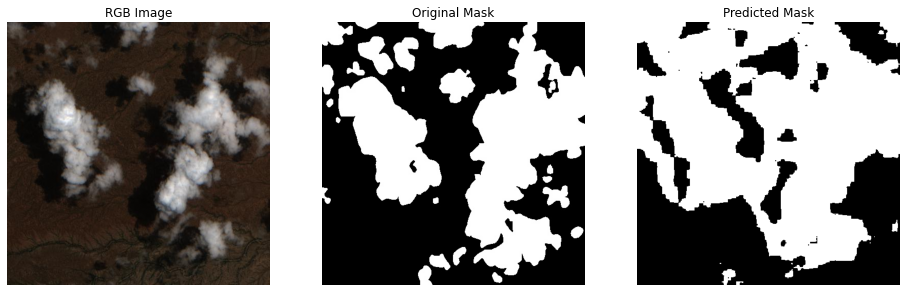

In [122]:
img = (load_img(os.path.join(rgb,ls[3]),expand_dim=True),
       load_img(os.path.join(false_color,ls[3]),expand_dim=True))
msk = cv2.imread(os.path.join(masks,ls[3]))
pred = model.predict(img)

fig,ax=plt.subplots(1,3,figsize=(16,8))
ax[0].set_title('RGB Image')
ax[0].imshow(img[0][0,:,:,::-1])
ax[0].axis('off')

ax[1].set_title('Original Mask')
ax[1].imshow(msk)
ax[1].axis('off')

ax[2].set_title('Predicted Mask')
ax[2].axis('off')
ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred[0]>0.5),cmap='gray')

plt.show()

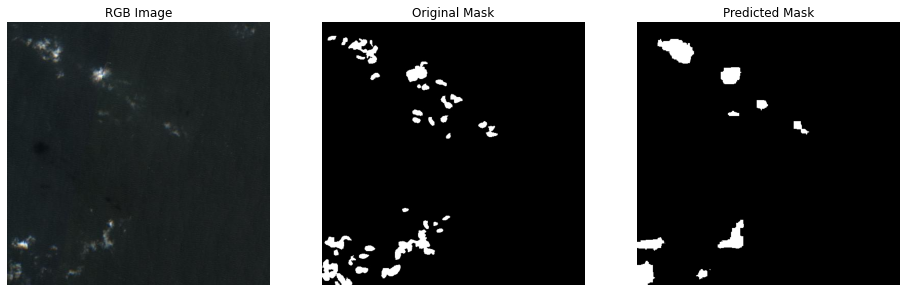

In [125]:
img = (load_img(os.path.join(rgb,ls[7]),expand_dim=True),
       load_img(os.path.join(false_color,ls[7]),expand_dim=True))
msk = cv2.imread(os.path.join(masks,ls[7]))
pred = model.predict(img)

fig,ax=plt.subplots(1,3,figsize=(16,8))
ax[0].set_title('RGB Image')
ax[0].imshow(img[0][0,:,:,::-1])
ax[0].axis('off')

ax[1].set_title('Original Mask')
ax[1].imshow(msk)
ax[1].axis('off')

ax[2].set_title('Predicted Mask')
ax[2].axis('off')
ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred[0]>0.5),cmap='gray')

plt.show()

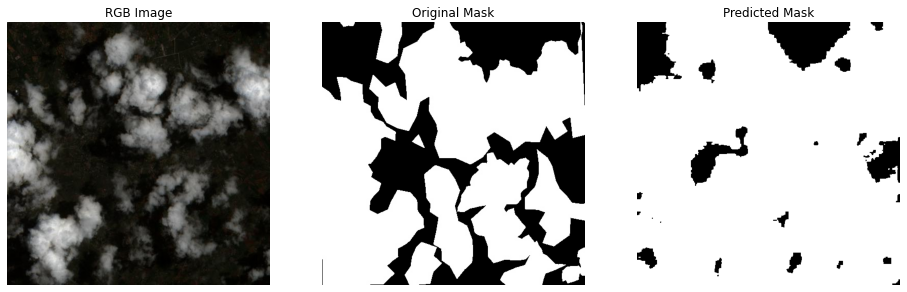

In [126]:
img = (load_img(os.path.join(rgb,ls[8]),expand_dim=True),
       load_img(os.path.join(false_color,ls[8]),expand_dim=True))
msk = cv2.imread(os.path.join(masks,ls[8]))
pred = model.predict(img)

fig,ax=plt.subplots(1,3,figsize=(16,8))
ax[0].set_title('RGB Image')
ax[0].imshow(img[0][0,:,:,::-1])
ax[0].axis('off')

ax[1].set_title('Original Mask')
ax[1].imshow(msk)
ax[1].axis('off')

ax[2].set_title('Predicted Mask')
ax[2].axis('off')
ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred[0]>0.5),cmap='gray')

plt.show()